# Previsão de vendas com de séries temporais usando a ferramenta Prophet

In [2]:
import requests, zipfile, io
zipurl = 'https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/rossman_train.zip'
r = requests.get(zipurl)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

> Carregando nosso dataset

In [5]:
# Loading our Datasets
train = pd.read_csv("rossman_train.csv", parse_dates = True, low_memory = False, index_col = 'Date')

# Load the additional store data
file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/rossman_store.csv"
store = pd.read_csv(file_name, low_memory=False)

# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [9]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [10]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Text(0.5, 0, 'Sale per Customer')

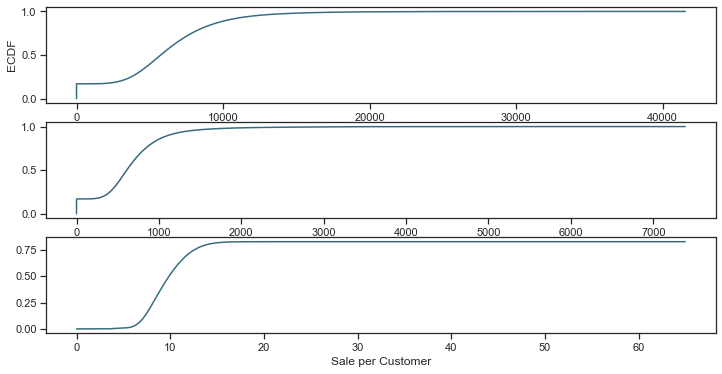

In [11]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer')

Lojas fechadas

In [12]:
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [13]:
len(train[(train.Open == 0) & (train.Sales == 0)])

172817

Existem 172817 lojas fechadas nos dados. É cerca de 10% da quantidade total de observações. Para evitar previsões tendenciosas, reduziremos esses valores.

E as lojas abertas com zero de vendas?

In [14]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", len(zero_sales))
zero_sales.head()

In total:  54


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Vamos remover as lojas que estavam fechadas e que não tiveram vendas

In [15]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

# additional information about the stores
store.head()

In total:  (844338, 13)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [21]:
store['CompetitionDistance'].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

In [22]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [23]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [24]:
store.fillna(0, inplace = True)

In [25]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [26]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


O StoreType B tem a maior média de vendas entre todas as outras, no entanto, temos muito menos dados para isso. Então, imprimamos uma soma geral de Vendas e Clientes para ver qual StoreType é o mais vendido e mais concorrido:

In [27]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Claramente, as lojas do tipo A. O StoreType D fica em segundo lugar em Vendas e Clientes. E quanto a períodos? Seaborn facet grid é a melhor ferramenta para esta tarefa:

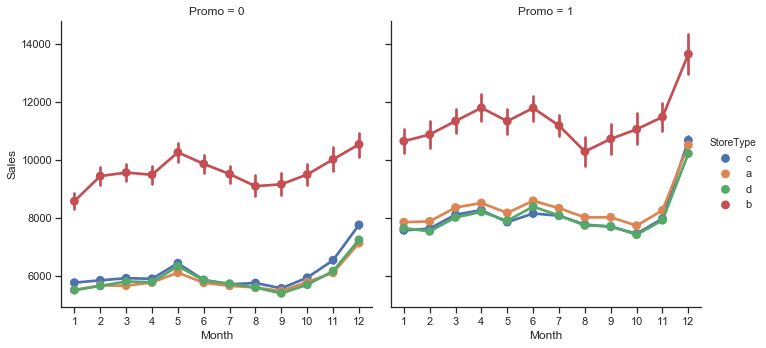

In [28]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", col = 'Promo',hue = 'StoreType') 

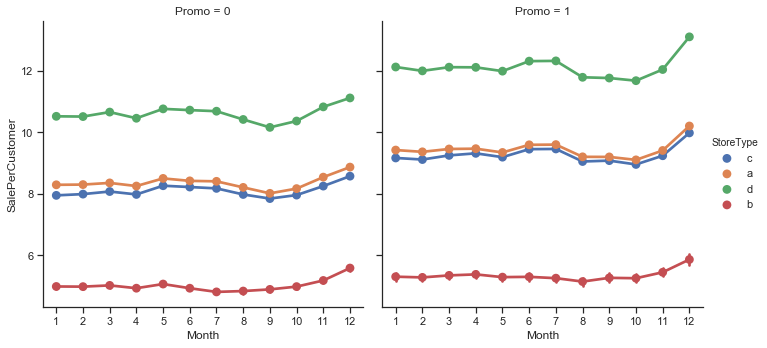

In [29]:
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", col = 'Promo',hue = 'StoreType')

Store Type B como a mais vendida e com melhor desempenho, na realidade não é verdade. O valor mais alto de SalePerCustomer é observado no StoreType D, cerca de 12 € com promoção e 10 € sem. Quanto ao StoreType A e C, são cerca de 9 €. O valor baixo de SalePerCustomer do StoreType B descreve seu perfil de compradores: muitas pessoas compram basicamente coisas "pequenas" (ou em pequena quantidade). Além disso, vimos que, em geral, esse StoreType gerou a menor quantidade de vendas e clientes durante o período. <br>


Para concluir nossa análise preliminar dos dados, podemos adicionar variáveis ​​que descrevem o período de tempo durante o qual a competição e a promoção foram abertas:

In [30]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### Matriz de Correlação

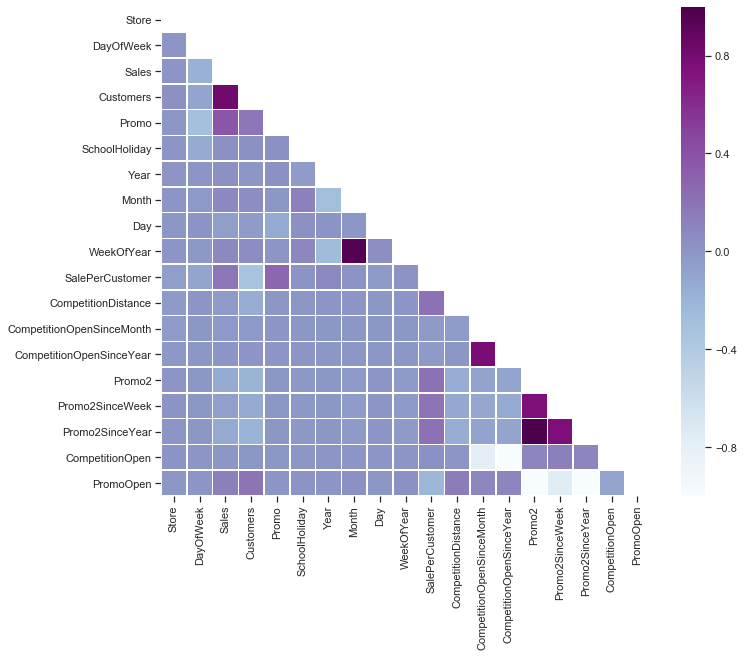

In [31]:
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")  

Como mencionado anteriormente, temos uma forte correlação positiva entre a quantidade de vendas e clientes de uma loja. Também podemos observar uma correlação positiva entre o fato de a loja ter uma promoção em execução (promoção igual a 1) e a quantidade de clientes. No entanto, assim que a loja continua uma promoção consecutiva (Promo2 igual a 1), o número de Clientes e Vendas parece permanecer o mesmo ou até diminuir, o que é descrito pela correlação negativa pálida no mapa de calor. A mesma correlação negativa é observada entre a presença da promoção na loja e o dia da semana

ValueError: Invalid RGBA argument: masked

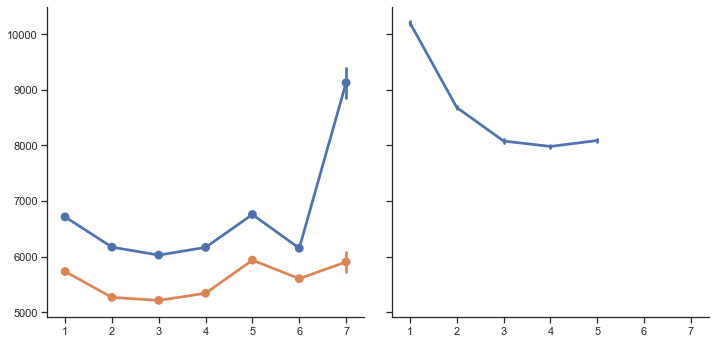

In [32]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", col = 'Promo',hue = 'Promo2')

Há várias coisas aqui:
- No caso de nenhuma promoção, tanto a Promoção quanto a Promoção2 são iguais a 0, as vendas tendem a atingir o pico no domingo (!). Embora devamos observar que o StoreType C não funciona aos domingos. Portanto, são principalmente dados do StoreType A, B e D.
- Pelo contrário, as lojas que executam a promoção tendem a fazer a maior parte das vendas na segunda-feira. Esse fato pode ser um bom indicador para as campanhas de marketing da Rossmann. A mesma tendência segue as lojas que têm as duas promoções ao mesmo tempo (Promo e Promo2 são iguais a 1).
- Promo2 por si só não parece estar correlacionado a nenhuma alteração significativa no valor das vendas. Isso também pode ser comprovado pela área azul pálida no mapa de calor acima.

# Análise de séries temporais por tipo de loja
O que diferencia uma série temporal de um problema de regressão regular?

- Depende do tempo. A suposição básica de uma regressão linear de que as observações são independentes não se aplica neste caso.
- Juntamente com uma tendência crescente ou decrescente, a maioria das séries temporais tem algum tipo de tendência de sazonalidade, ou seja, variações específicas para um período de tempo específico. Por exemplo, nas férias de Natal, que veremos neste conjunto de dados.
Construímos uma análise de séries temporais nos tipos de loja, e não nas lojas individuais. A principal vantagem dessa abordagem é sua simplicidade de apresentação e a conta geral de diferentes tendências e sazonalidades no conjunto de dados.

Nesta seção, analisaremos os dados de séries temporais: suas tendências, sesonalidades e autocorrelação. Normalmente, no final da análise, somos capazes de desenvolver um modelo sazonal ARIMA (Média Móvel Integrada de Regressão Automática), mas esse não será nosso foco principal hoje. Em vez disso, tentamos entender os dados e só mais tarde apresentamos as previsões usando a metodologia Prophet.

## Sazonalidade
Tomamos quatro lojas de tipos de loja para representar seu grupo:
- Número da loja 2 para StoreType A
- número da loja 85 para o StoreType B,
- Número da loja 1 para StoreType C
- Número da loja 13 para StoreType D.
Também faz sentido reduzir a amostra dos dados de dias para semanas usando o método de nova amostra para ver as tendências atuais com mais clareza.

Bug do Prophet - https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/

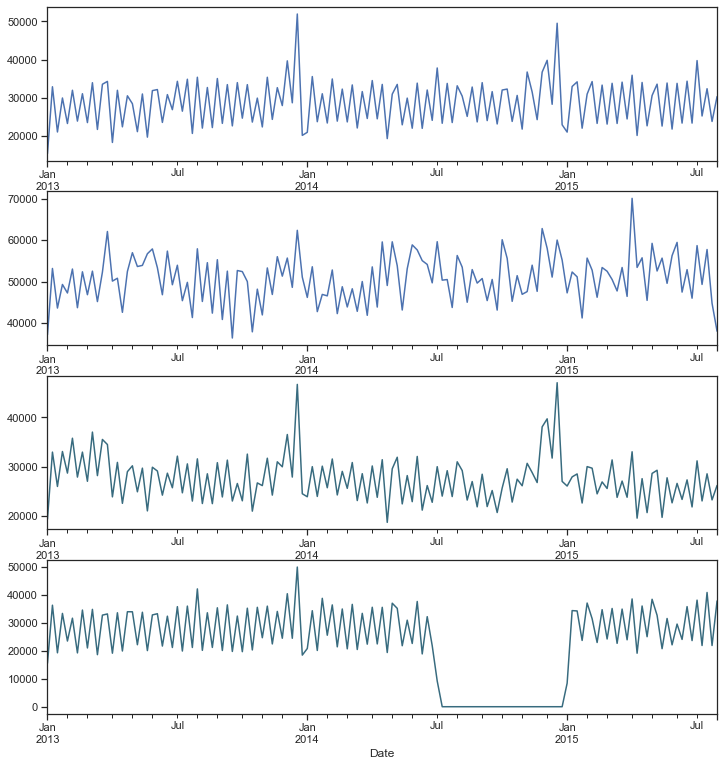

In [33]:
# Prophet Bug - Prophet deregisters the Pandas converters in its code.
pd.plotting.register_matplotlib_converters()

# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Checando a presença de tendeência nas séries

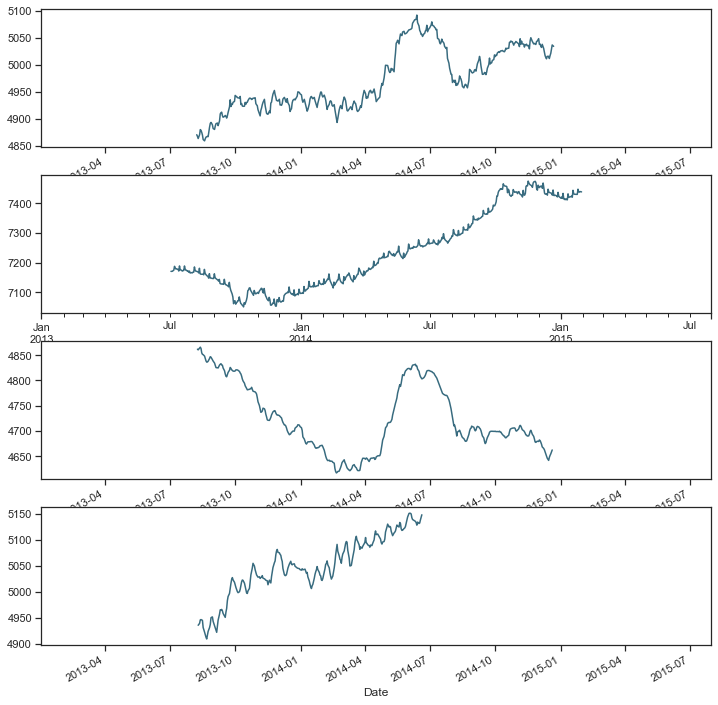

In [34]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

As vendas gerais parecem aumentar, mas não para o StoreType C (um terço do topo). Mesmo que o StoreType A seja o tipo de loja mais vendido no conjunto de dados, parece que ele segue a mesma trajetória decrescente do StoreType C.

Autocorrelação
O próximo passo na análise de séries temporais é revisar os gráficos de Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF).

O ACF é uma medida da correlação entre as séries temporais com uma versão atrasada de si mesma. Por exemplo, no atraso 5, o ACF compararia séries no instante de tempo 't1' ... '' 'com séries no instante' t1-5 '...' tn-5 '(t1-5 e tn sendo pontos finais).

O PACF, por outro lado, mede a correlação entre as séries temporais com uma versão atrasada de si mesma, mas após eliminar as variações explicadas pelas comparações intermediárias. Por exemplo. no atraso 5, ele verificará a correlação, mas removerá os efeitos já explicados nos lags 1 a 4.

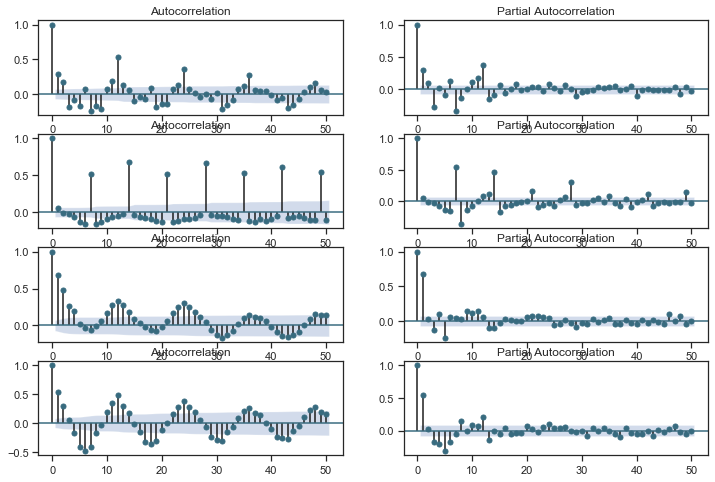

In [35]:
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

Podemos ler esses gráficos horizontalmente. Cada par horizontal é para um 'StoreType', de A a D. Em geral, esses gráficos mostram a correlação da série consigo mesma, defasada por x unidades de tempo correlação da série consigo mesma, defasada por x unidades de tempo. Há duas coisas comuns para cada par de parcelas: não aleatórias da série temporal e alto lag-1 (que provavelmente precisará de uma ordem maior de diferença d / D). Tipo A e tipo B: os dois tipos mostram sazonalidades em certos atrasos. Para o tipo A, é cada 12ª observação com picos positivos nos intervalos de 12 (s) e 24 (2s) e assim por diante. Para o tipo B, é uma tendência semanal com picos positivos nas defasagens 7 (s), 14 (2s), 21 (3s) e 28 (4s). Tipo C e tipo D: os gráficos desses dois tipos são mais complexos. Parece que cada observação está correlacionada com as observações adjacentes.

# Análise e previsão de séries temporais com o Profeta¶
Previsão para as próximas 6 semanas para a primeira loja!

A equipe de Core Data Science do Facebook publicou recentemente um novo procedimento para prever dados de séries temporais chamado Profeta. Baseia-se em um modelo aditivo no qual tendências não lineares se ajustam à sazonalidade anual e semanal, além de feriados. Ele permite realizar previsões automatizadas que já estão implementadas em R em escala no Python 3.

In [39]:
# Loading our Datasets
df = pd.read_csv("rossman_train.csv", parse_dates = True, low_memory = False, index_col = 'Date')

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [40]:
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales = sales.reset_index()
del sales['ds']
sales = sales.rename(columns = {'Date': 'ds'})
sales

,ds,y
0,2015-07-31,5263
1,2015-07-30,5020
2,2015-07-29,4782
3,2015-07-28,5011
4,2015-07-27,6102
5,2015-07-25,4364
6,2015-07-24,3706
7,2015-07-23,3769
8,2015-07-22,3464
9,2015-07-21,3558


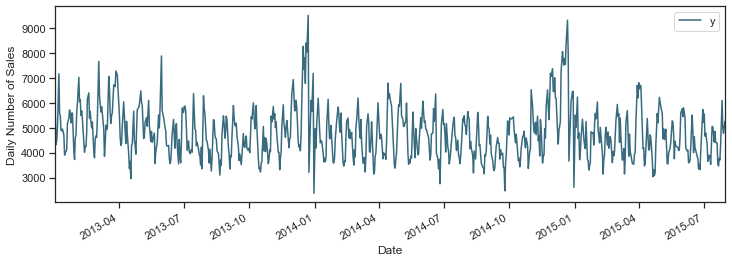

In [41]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

## Modelagem de feriados
Prophet também permite modelar para feriados, e é isso que fazemos aqui.

A variável StateHoliday no conjunto de dados indica um feriado do estado, no qual todas as lojas são normalmente fechadas. Também há férias escolares no conjunto de dados em que as lojas de ceratin também estão fechando suas portas.

In [42]:
# create holidays dataframe
state_dates  = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].reset_index().loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].reset_index().loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04
